In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [59]:
args = {
    "dataset": r"D:\deep learning\garbage detection", 
    "plot": "plot.png",
    "model": "mask_detectorch.model"
}

In [60]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [61]:
print("[INFO] loading images from the dataset...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

[INFO] loading images from the dataset...


In [62]:
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
	labels.append(label)

In [63]:
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [66]:
lb =LabelEncoder()
labels = lb.fit_transform(labels)

In [67]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [84]:
from tensorflow.keras.utils import to_categorical

trainY = to_categorical(trainY)
testY = to_categorical(testY)


In [85]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [86]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

In [79]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

In [80]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [81]:
for layer in baseModel.layers:
	layer.trainable = False

In [82]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [83]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
63/63 [==============================] - 37s 561ms/step - loss: 1.7189 - accuracy: 0.3414 - val_loss: 1.2214 - val_accuracy: 0.5909
Epoch 2/10
63/63 [==============================] - 40s 627ms/step - loss: 1.2715 - accuracy: 0.5214 - val_loss: 0.9412 - val_accuracy: 0.6937
Epoch 3/10
63/63 [==============================] - 38s 608ms/step - loss: 1.0464 - accuracy: 0.6063 - val_loss: 0.8383 - val_accuracy: 0.6858
Epoch 4/10
63/63 [==============================] - 39s 613ms/step - loss: 0.9367 - accuracy: 0.6526 - val_loss: 0.7407 - val_accuracy: 0.7391
Epoch 5/10
63/63 [==============================] - 36s 570ms/step - loss: 0.8461 - accuracy: 0.6823 - val_loss: 0.6870 - val_accuracy: 0.7589
Epoch 6/10
63/63 [==============================] - 42s 661ms/step - loss: 0.7721 - accuracy: 0.7280 - val_loss: 0.6481 - val_accuracy: 0.7609
Epoch 7/10
63/63 [==============================] - 41s 654ms/step - loss: 0.7386 - accuracy: 0.7345 - val_loss: 0.615

In [87]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...
16/16 [==============================] - 7s 411ms/step


In [94]:
print(np.unique(testY.argmax(axis=1)))
print(np.unique(predIdxs))
print(np.unique(trainY.argmax(axis=1)))
print(predIdxs.shape)


[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
(506,)


In [96]:
target_names = ["Plastic", "Paper", "Trash", "Metal", "Glass",'Cardboard']  
testY = np.argmax(testY, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=target_names))


              precision    recall  f1-score   support

     Plastic       0.95      0.85      0.90        81
       Paper       1.00      0.19      0.31       425
       Trash       0.00      0.00      0.00         0
       Metal       0.00      0.00      0.00         0
       Glass       0.00      0.00      0.00         0
   Cardboard       0.00      0.00      0.00         0

    accuracy                           0.29       506
   macro avg       0.32      0.17      0.20       506
weighted avg       0.99      0.29      0.41       506



C:\Users\anora\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anora\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anora\Downloads\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [97]:
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

[INFO] saving mask detector model...


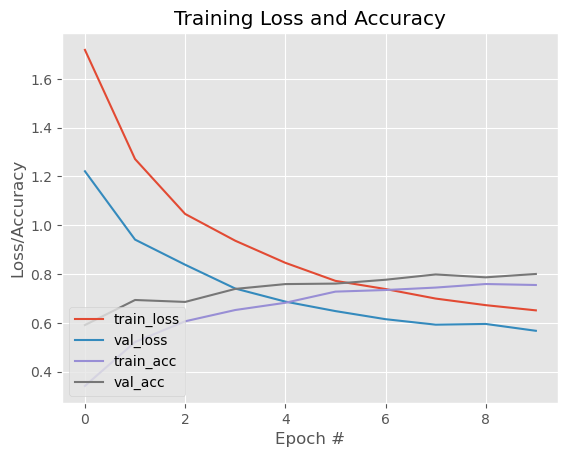

In [98]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])


In [99]:
model.save("garbage_classifier.h5")
